# **CV Task 3**

## **DJS Synapse Learning Period**
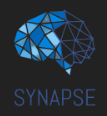

## importing and installing stuff

In [30]:
!pip install pydicom -q

In [31]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

## theoretical background

Until now, you have played around with Convolutional Neural Networks. For years, they were the dominant force in Computer Vision. Until a groundbreaking paper introduced transformers. Initially introduced for Natural Language Processing tasks, they were then also employed in Computer Vision as well. This is that original paper:

[Attention is All you Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

If you didn't understand too much from that, worry not. Go through below resources as well:

[Basic overview (from an NLP viewpoint)](https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04)

[A bit more in depth (again, from an NLP viewpoint)](https://towardsdatascience.com/transformers-141e32e69591)


To get more background on how exactly vision transformers work:

[For visual learners](https://youtu.be/qU7wO02urYU?si=bj8Xj-DG2qDbwdnH)

[Read through this as well](https://www.v7labs.com/blog/vision-transformer-guide)

Transformers found their initial applications in natural language processing (NLP) tasks. To use this NLP model for computer vision tasks, we have to divide our input image into patches. After flattening the patches, we can treat each flattened patches as single word. We add positional embeddings to the linear projection of flattened patches. An extra token is added at the beginning for classification tasks. In BERT model, this token is called [CLS] token.

So if our input image size is (512, 512), after dividing the image into patches of size (16, 16), we get 1024 (32 times 32) patches. After flattening the patches and projecting the flattened patches, we have 1024 tokens. After adding positional embeddings and concatenating classification token at the beginning, we have 1025 tokens.

We then feed our tokens into the transformer encoder. Transformer encoder is made up of self attention and feedforward network. This [video](https://www.youtube.com/watch?v=_UVfwBqcnbM) by AssemblyAI explains the transformer architecture beautifully.

The number of tokens in the output of the transformer encoder is equal to number of input tokens. We take the first token from the output (corresponds to the classification token) and feed the token in a multilayer perceptron head for classification.

## dataset info
The dataset was contributed by mammography screening programs in Australia and the U.S. It includes detailed labels, with radiologists’ evaluations and follow-up pathology results for suspected malignancies.

The dataset is stored in dicom formats. Converting dicom data to png/jpg just by rescaling it will harm the quality of the data. [This notebook](https://www.kaggle.com/code/raddar/convert-dicom-to-np-array-the-correct-way/notebook) is an awesome resource for anyone working with dicom files for X-Ray.

To know more about how dicom images work, go through [this](https://towardsdatascience.com/understanding-dicom-bce665e62b72). They are specially used for X - Ray images.

## utility functions
We write some utility functions beforehand. To know how to work with PyDicom funtions, read [this](https://towardsdatascience.com/introducing-pydicom-its-classes-methods-and-attributes-518c1d71162).

In [32]:
import pydicom
def read_xray(file_path, img_size=None):
    """
    Read the dicom data and get the image
    Args:
        file_path: The path of the dicom file
        img_size: Size of the output image
    """

    dicom = pydicom.dcmread(file_path)
    # read file_path using pydicom
    img = dicom.pixel_array
    # assign as pixel_array

    if dicom.PhotometricInterpretation=="MONOCHROME1": 
      # check if the photo is Monochrome
        img = np.max(img) - img # we are inverting the pixel values. can you guess why?so that the bright regions are represented with high values and dark regions are represented with low values.

    if img_size:
        img = cv2.resize(img,img_size)
        # resize to img_size

    # Add channel dim at First
    img = img[np.newaxis]

    # Converting img to float32
    img = img/np.max(img)
     # normalize img
    img = img.astype('float32')
    # convert to float32

    return img

In [33]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images

    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    # assign shape of batch
    ph, pw = patch_size
     # which size should be assigned here?
    nh, nw = h//ph,w//pw
    # calculate this

    # Look into torch.reshape to get the patches
    # then, change the order of dimensions as required for the output using torch.permute
    batch_patches = torch.reshape(batch,(b,c,nh,ph,nw,pw))

    batch_patches = torch.permute(batch_patches,(0,2,4,1,3,5))

    return batch_patches

We test our `patchify` function on a single image.

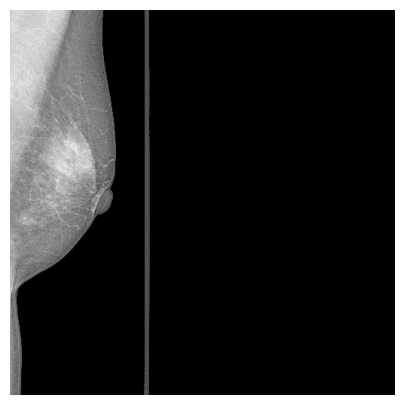

In [34]:
FILE_PATH = ('/kaggle/input/rsna-breast-cancer-detection/'
             'train_images/10006/1459541791.dcm')

img = read_xray(FILE_PATH, img_size=(512, 512))

batch = torch.tensor(img[None])
patch_size = (16, 16)
batch_patches = patchify(batch, patch_size)

patches = batch_patches[0]
c, nh, nw, ph, pw = patches.shape

plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap="gray")
plt.axis("off")

plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j], cmap="gray")
        plt.axis("off")

In [36]:
def get_mlp(in_features, hidden_units, out_features):
    """
    Returns a MLP head
    """
    dims = [in_features] + hidden_units + [out_features]
    layers = []
    for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
        layers.append(nn.Linear(dim1,dim2))
        layers.append(nn.ReLU())
      
        # Add a Linear ReLU Layer to layers for each iteration

    # Add a final Linear Layer and return its Sequential Model
    layers.append(nn.Linear(dims[-2],dims[-1]))
    return nn.Sequential(*layers)

## image to sequence block
This Block takes a batch of image as input and returns a batch of sequences. Later on we feed this sequences into the transformer encoder.

In [42]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences

    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.linear = layers.append(nn.Linear(token_dim,d_model))
        # Create a Linear layer with appropriate dimensions

        # we create 2 Learnable Parameters using torch.randn for initialization.
        # one is the Embedding Parameter of a Special Transformer Token.
        # the other is the Positional Embeddings.
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

    def __call__(self, batch):
        batch = patchify(batch, self.patch_size)

        b, c, nh, nw, ph, pw = batch.shape

        # Flattening the patches using reshape and permute. Adjust Dimensions carefully.
        batch=torch.reshape(batch,(b,c,nh,nw,ph*pw))
        batch = torch.permute(batch,(0,2,3,4,1))

        batch = self.linear(batch)
        cls = self.cls_token.expand([b, -1, -1])
        emb = batch + self.pos_emb

        return torch.cat([cls, emb], axis=1)

## visual transformer module
This modules wraps up everything. We can divide this module into 3 parts:
* An image to sequence encoder
* Transformer encoder
* Multilayer perceptron head classification

We use `torch.nn.TransformerEncoder` and `torch.nn.TransformerEncoderLayer` to implement our transformer encoder. We highly recommend to read the official documentation to [learn more about the layers](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html).
For the loss function, we will be using [gelu](https://arxiv.org/abs/1606.08415). You can also use this video to [learn about it](https://www.youtube.com/watch?v=FWhMkpo9yuM).

In [75]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        
        
        img_size: (512,512)
        patch_size: (16,16)
        n_channels: 3
        d_model: 1024
        nhead: 4
        dim_feedforward: 1024
        blocks: 8
        mlp_head_units: [512,512]
        n_classes: 1
        
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        # create an encoder layer for the head of the model using Gelu activation.
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, activation='gelu',batch_first=True)
        
        # make sure you set the parameter that gives output as (batch_size, sequence, feature)

       

        # create an encoder block
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, blocks)
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)

        # create the output activation function based on the number of classes (sigmoid or softmax)
        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax()

    def __call__(self, batch):

        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        batch = self.mlp(batch)
        output = self.output(batch)
        return output

## training

Here, we design a simple training to loop to train or `ViT` model on a subset of dataset. We use an already cropped dataset.

In [76]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## dataset loading
We will be using the [CLAHE](https://www.geeksforgeeks.org/clahe-histogram-eqalization-opencv/) algorithm to improve contrast between the tiled images. Apart from this, we are using the pytorch data handling modules like DataLoaded which you can read about [here](https://pytorch.org/docs/stable/data.html).

In [77]:
class RSNADataset(Dataset):

    def __init__(self, df, img_path):
        self.df = df
        self.img_path = img_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient_id, image_id, cancer = self.df.iloc[idx][['patient_id', 'image_id', 'cancer']]
        file = os.path.join(self.img_path, f'{patient_id}_{image_id}.png')
        file = cv2imread(file, cv2.IMREAD_GRAYSCALE)
        # read file
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # use cv2.createCLAHE
        file = clahe.apply(file)
        # apply clahe to file
        file = file.astype('float32')/255.0
        # normalize file
        X = torch.tensor(file[np.newaxis].astype('float32')).to(device)
        y = torch.tensor([cancer]).float().to(device)
        return X, y

In [78]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
counts = df['cancer'].value_counts()
 # apply value_counts on appropriate column
df['weights'] = df['cancer'].apply(lambda x: 1/counts[x]) # why this?

train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['cancer'])

In [79]:
img_path = '/kaggle/input/rsna-breast-cancer-512-pngs'
train_samples = 1000
val_samples = 500


train_ds = RSNADataset(train_df, img_path)
val_ds = RSNADataset(val_df,img_path)
# call as above


train_sampler = WeightedRandomSampler(train_df['weights'].values, train_samples)
train_loader = DataLoader(train_ds, batch_size=8, sampler=train_sampler)

val_sampler = WeightedRandomSampler(val_df['weights'].values,val_samples)
 # sample as above
val_loader = DataLoader(val_ds, batch_size=8,sampler=val_sampler)
# load as above

## model creation and training start

In [80]:
model = ViT(
    img_size = (512, 512),
    patch_size = (16, 16),
    n_channels = 1,
    d_model = 1024,
    nhead = 4,
    dim_feedforward = 1024,
    blocks = 8,
    mlp_head_units = [512, 512],
    n_classes = 1,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
# run Adam optimizer on model
criterion = nn.BCEWithLogitsLoss()
# use BCE Loss

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_metrics = {
    "bce": Loss(criterion)
}
evaluator =  create_supervised_evaluator(model, metrics=val_metrics, device=device)
 # create evaluator trainer

NameError: name 'layers' is not defined

In [29]:
log_interval = 10
max_epochs = 5
best_loss = float('inf')

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

pbar = ProgressBar()
pbar.attach(trainer, ['loss'])

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_loss
    evaluator.run(val_loader)
    loss = evaluator.state.metrics['bce']
    if loss < best_loss:
        best_loss=loss

        # in this line, save best loss in best_loss
        torch.save(model.state_dict(), 'best_model_vit.pt')
        # in this line, use torch.save() to save model as 'best_model_vit.pt'
    print(f"Validation Results - Epoch: {trainer.state.epoch} Avg loss: {loss:.2f}")

output_state = trainer.run(train_loader, max_epochs=max_epochs)

NameError: name 'trainer' is not defined

# **End of Task**

> ©Synapse 2024 - 2025
